Forecast for dixie sales
---

Forecast A:
Forecast Net Exchange per customer, per month,
with a forecast horrizon of 12 months

Forecast B:
Forecast Net Qty per Functional Category, Build type, and month,
with a forecast horizon of 12 months

In [1]:
%matplotlib inline
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pandas.plotting import autocorrelation_plot
import datetime as dt
from dotenv import load_dotenv
load_dotenv()

# Ignore statsmodels convergence warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore',ConvergenceWarning)

# Import scripts after loading evnironment to check for refresh flag
import scripts

In [2]:
# Get data from SQL (or cache)
invoices = scripts.Invoices.load(refresh=False)
accounts = scripts.Accounts.load(refresh=False)
accounts.head(20)

Loading invoices data from csv...
Loading accounts data from csv...


,Unnamed: 0,account_number,ExchangeTotal
0,0,DIXMN,1786240.91
1,1,SMHCO,1515309.12
2,2,CATIN,1115480.42
3,3,DIXM2,1105669.81
4,4,QUDEL,1065010.17
5,5,REMIN,904543.72
6,6,VOLBY,745726.53
7,7,MOTOR,722813.35
8,8,ELRDI,392059.04
9,9,CUMIN,354467.82


In [3]:
# account = accounts.account_number[0]
account = 'KEYGE'
sales_df = invoices[invoices.account_number == account].resample('M').sum().filter(['NetExchange'])
# sales_df.info()

In [4]:
 # Calculate split point and split data
split_index = int(len(sales_df) * 0.95)
df_train, df_test = sales_df[:split_index], sales_df[split_index:]
X_train = df_train.index.map(dt.datetime.toordinal).values.reshape(-1, 1)
y_train = df_train.NetExchange.values.reshape(-1, 1)
X_test = df_test.index.map(dt.datetime.toordinal).values.reshape(-1, 1)
y_test = df_test.NetExchange.values.reshape(-1, 1)
# X_train.shape, y_train.shape, X_test.shape, y_test.shape

<AxesSubplot:xlabel='proc_date'>

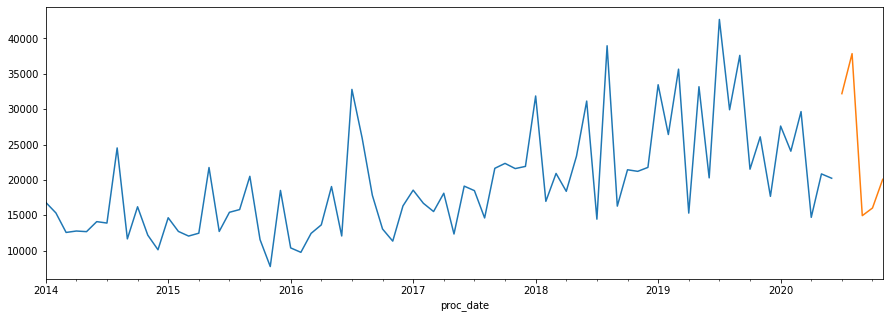

In [5]:
endog = df_train.NetExchange
endog.plot(figsize=(15,5))
exog = df_test.NetExchange
exog.plot()

Calculating step-through forecasts...
Calculating MAD...
Calculating MAPE...
0.3269630980673784


<AxesSubplot:xlabel='proc_date'>

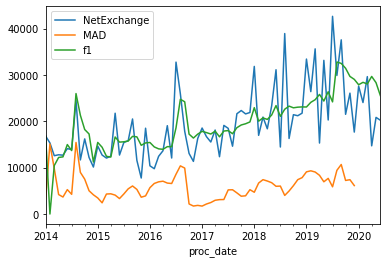

In [20]:
def gen_forecast(df, step):
    try:
        mod = sm.tsa.SARIMAX(df, order=(1,1,1), trend='c')
        res = mod.fit()
        fcast_res = res.forecast(steps=step)[-1]
        return fcast_res
    except:
        return 0
df = df_train.copy()
print('Calculating step-through forecasts...')
df['f1'] = df.NetExchange.expanding().apply(gen_forecast,args=(1,))
df['f2'] = df.NetExchange.expanding().apply(gen_forecast,args=(2,))
df['f3'] = df.NetExchange.expanding().apply(gen_forecast,args=(3,))
df['f4'] = df.NetExchange.expanding().apply(gen_forecast,args=(4,))
df['f5'] = df.NetExchange.expanding().apply(gen_forecast,args=(5,))
df['f6'] = df.NetExchange.expanding().apply(gen_forecast,args=(6,))
print('Calculating MAD...')
df['MAD'] = ((df.f1-df.shift(-1).NetExchange).abs() + \
    (df.f2-df.shift(-2).NetExchange).abs() + \
    (df.f3-df.shift(-3).NetExchange).abs() + \
    (df.f4-df.shift(-4).NetExchange).abs() + \
    (df.f5-df.shift(-5).NetExchange).abs() + \
    (df.f6-df.shift(-6).NetExchange).abs())/6
print('Calculating MAPE...')
df['MAPE'] = ((df.f1-df.shift(-1).NetExchange).abs()/df.shift(-1).NetExchange.abs()+ \
    (df.f2-df.shift(-2).NetExchange).abs()/df.shift(-2).NetExchange.abs() + \
    (df.f3-df.shift(-3).NetExchange).abs()/df.shift(-3).NetExchange.abs() + \
    (df.f4-df.shift(-4).NetExchange).abs()/df.shift(-4).NetExchange.abs() + \
    (df.f5-df.shift(-5).NetExchange).abs()/df.shift(-5).NetExchange.abs() + \
    (df.f6-df.shift(-6).NetExchange).abs()/df.shift(-6).NetExchange.abs())/6
print(df.MAPE.mean())
# print(df.to_string())
df[['NetExchange','MAD', 'f1']].plot()

In [27]:
def gen_forecast(df, step):
    print(df)
    mod = sm.tsa.ExponentialSmoothing(endog=df)
    res = mod.fit()
    fcast_res = res.forecast(steps=step)[-1]
    return fcast_res
df = df_train.copy()
print('Calculating step-through forecasts...')
df['f1'] = df.NetExchange.expanding().apply(gen_forecast,args=(1,))
df['f2'] = df.NetExchange.expanding().apply(gen_forecast,args=(2,))
df['f3'] = df.NetExchange.expanding().apply(gen_forecast,args=(3,))
df['f4'] = df.NetExchange.expanding().apply(gen_forecast,args=(4,))
df['f5'] = df.NetExchange.expanding().apply(gen_forecast,args=(5,))
df['f6'] = df.NetExchange.expanding().apply(gen_forecast,args=(6,))
print('Calculating MAD...')
df['MAD'] = ((df.f1-df.shift(-1).NetExchange).abs() + \
    (df.f2-df.shift(-2).NetExchange).abs() + \
    (df.f3-df.shift(-3).NetExchange).abs() + \
    (df.f4-df.shift(-4).NetExchange).abs() + \
    (df.f5-df.shift(-5).NetExchange).abs() + \
    (df.f6-df.shift(-6).NetExchange).abs())/6
print('Calculating MAPE...')
df['MAPE'] = ((df.f1-df.shift(-1).NetExchange).abs()/df.shift(-1).NetExchange.abs()+ \
    (df.f2-df.shift(-2).NetExchange).abs()/df.shift(-2).NetExchange.abs() + \
    (df.f3-df.shift(-3).NetExchange).abs()/df.shift(-3).NetExchange.abs() + \
    (df.f4-df.shift(-4).NetExchange).abs()/df.shift(-4).NetExchange.abs() + \
    (df.f5-df.shift(-5).NetExchange).abs()/df.shift(-5).NetExchange.abs() + \
    (df.f6-df.shift(-6).NetExchange).abs()/df.shift(-6).NetExchange.abs())/6
print(df.MAPE.mean())
print(df.to_string())
df[['NetExchange','MAD']].plot()

Calculating step-through forecasts...


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [7]:
# Construct the model
mod = sm.tsa.SARIMAX(endog, order=(1, 0, 0), trend='c')
# Estimate the parameters
res = mod.fit()

# print(res.summary())

In [8]:
fcast_res1 = res.get_forecast()

# Most results are collected in the 'summary_frame' attribute.
# Here we specify that we want a confidence level of 90%
print(fcast_res1.summary_frame(alpha=0.1))

NetExchange          mean      mean_se  mean_ci_lower  mean_ci_upper
2020-07-31   19691.659422  7200.195265    7848.392126   31534.926719


Specifying the number of forecasts
---

In [9]:
# print(res.forecast(steps=2))

In [10]:
fcast_res2 = res.get_forecast(steps=2)
# Note: since we did not specify the alpha parameter, the
# confidence level is at the default 95%
# print(fcast_res2.summary_frame())

In [11]:
fcast_res3 = res.get_forecast('2020-12-31')
# print(fcast_res3.summary_frame())

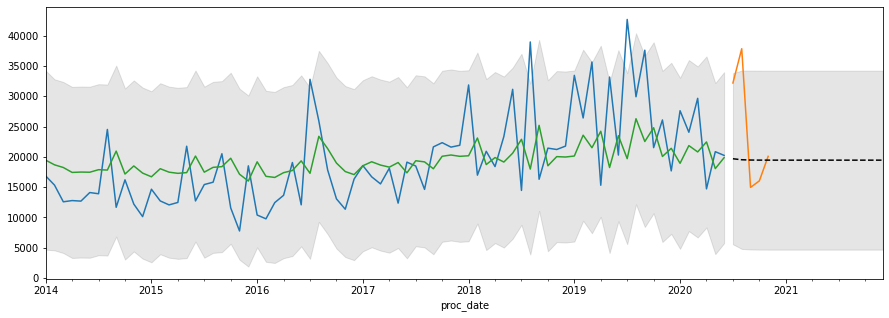

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
endog.loc['2010':].plot(ax=ax)
exog.plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast('2021-12-31').summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1)

pred = res.get_prediction().summary_frame()
pred['mean'].plot(ax=ax)
ax.fill_between(pred.index, pred['mean_ci_lower'], pred['mean_ci_upper'], color='k', alpha=0.1)